In [2]:
import sys
sys.path.append('..')
import config

import pandas as pd
import os
import re
from pymongo import MongoClient
import time              #for time of execution
import datetime          #for time of execution
import queue             #for multithreading
import threading         #for multithreading
import inspect           #for fit
import numpy as np       #for fit
import warnings          #for fit
import scipy.optimize as optimization       #for fit
from scipy.optimize import OptimizeWarning  #for fit
warnings.simplefilter(action='ignore', category=OptimizeWarning)  #for fit
import matplotlib.pyplot as plt             #for fit visualization
import seaborn as sns                       #for fit visualization

# Connect to MongoDB
client = MongoClient(config.__host, config.__port)


In [3]:
RESULTS_DIR = "./results_new"
__db_name = "scipub_2"
main_collection_name = "scipub_minimal_venus"

def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return

makedir(RESULTS_DIR)
print('Is connection estabilished? {0}'.format(client[__db_name][main_collection_name].count_documents({}) != 0))


Is connection estabilished? True


## Create scores

In [49]:
initial_years = [2000, 2004]
influence_years = [2005, 2014]
max_time_window_size = 6
total_correlations = pd.DataFrame()


In [207]:

####################### Calculate raw data for scores ###########################

#papers written by a list of items, with the year of publication
def list_of_papers(list_of_items, field_name, range_of_years=None, local_collection=main_collection_name):
    if len(list_of_items) == 0:
        return {}
    pipeline = [
            {'$match': {field_name: {'$in': list_of_items}}}, 
    ]
    
    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline)

#papers written by a list of items, with the year of publication
def list_of_papers_in_topic(topic_id, threshold, range_of_years=None, local_collection=main_collection_name):
    if len(list_of_items) == 0:
        return {}
    pipeline = [
            {'$project': {'_id': 0, 'acm_id': 1, 'topics': 1, 'authors': 1 }}, 
            {'$unwind': '$topics' }, 
            {'$match': {'topics.id': topic_id, 'topics.weight': {'$gte': threshold} }},
    ]
    
    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline)

#calculate time windows from interval
def get_time_windows(year_from, year_to, time_window_size, overlap):
    if overlap >= time_window_size:
        return []
    time_window_size-=1; overlap -= 1; year_to+= 1
    res = []
    i = 0
    while (year_from + i*(time_window_size-overlap) + time_window_size) < year_to:
        res += [[year_from + i*(time_window_size-overlap), year_from + i*(time_window_size-overlap) + time_window_size]]
        i += 1
    return res

#citations received by a list of papers, grouped by year
#  trace_single to True if the citations must be count singularly for each paper on list
#  -> if False, when a paper cites more than one paper of the list, it is counted only once;
#  count_papers_in_list to False if papers in list_of_id must not be counted in citations
#  count_only_first to True if the papers must be counted only the first time they cite the source paper
def paper_citations_by_year(list_of_id, range_of_years=None, count_papers_in_list=True, trace_single=False, count_only_first=False, local_collection=main_collection_name):
    #"""
    if len(list_of_id) == 0:
        return {}
    elif len(list_of_id) == 1:
        pipeline = [
                    {'$match': {'acm_id': list_of_id[0]}}, 
        ]
    else:
        pipeline = [
                    {'$match': {'acm_id': {'$in': list_of_id}}}, 
        ]

    pipeline = pipeline + [
                #{'$match': {'acm_id': acm_id[0]}},
                {'$unwind': '$acm_cited_by'}, 
    ]
    
    if not(count_papers_in_list):
        pipeline = pipeline + [
                    {'$match': {'acm_cited_by.acm_id': {'$nin': list_of_id}}},
        ]
    
    if range_of_years != None:
        pipeline = pipeline + [
                    {'$match': {'acm_cited_by.year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ]
    
    if trace_single:
        pipeline = pipeline + [
                    {'$project': {'_id' :0, 'acm_id': '$acm_cited_by.acm_id', 'year': '$acm_cited_by.year', 'authors': '$acm_cited_by.authors', 'cites': '$acm_id'}},
                    {'$sort': {'cites':1, 'year': 1}}
        ]
        if count_only_first:
            pipeline = pipeline + [
                        {'$group': {'_id' : {'acm_id': '$acm_id', 'cites': '$cites'}, 'year': { '$first': '$year' }, 'authors': { '$first': '$authors' }}},
                        {'$project': {'_id' :0, 'acm_id': '$_id.acm_id', 'cites': '$_id.cites', 'year': '$year', 'authors': '$authors'}},
            ]
    else:
        pipeline = pipeline + [
                    {'$project': {'_id' :0, 'acm_id': '$acm_cited_by.acm_id', 'year': '$acm_cited_by.year', 'authors': '$acm_cited_by.authors'}},
                    {'$sort': {'year': 1}}
        ]
        if count_only_first:
            pipeline = pipeline + [
                        {'$group': {'_id' : '$acm_id', 'year': { '$first': '$year' }, 'authors': { '$first': '$authors' }}},
                        {'$project': {'_id' :0, 'acm_id': '$_id', 'year': '$year', 'authors': '$authors'}},
            ]

    return local_collection.aggregate(pipeline, allowDiskUse=True)

#papers written by a list of authors, with the year of first (or last) publication
def list_of_authors(list_of_papers=None, range_of_years=None, local_collection=main_collection_name):
    
    pipeline = [
            {'$project': {'_id' :0, 'authors': 1, 'year': 1}},
            {'$unwind': '$authors'}, 
            {'$sort': {'authors': 1, 'year': 1}},
            {'$group': {'_id' : '$authors', 'year_first': {'$first': '$year'}, 'year_last': {'$last': '$year'} }},
            {'$project': {'_id' :0, 'author': '$_id', 'year_first': '$year_first', 'year_last': '$year_last', 'range_of_years': {'$subtract': [ "$year_last", "$year_first" ]} }},
    ]

    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline

    if list_of_papers != None:
        pipeline = [
                    {'$match': {'_id': {'$in': list_of_papers}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#
# layer 0 shows the initial data
def get_windows_authors(initial_papers, time_windows, local_collection):
    res = {"layer":[], "number_of_papers":[], "number_of_authors":[], "number_of_new_authors":[]} #pd.DataFrame( {"layer":[], "acm_id":[]} )
    if initial_papers == []:
        return res
    #exclude initial papers from results
    excluded_papers = initial_papers[:]
    excluded_authors = [x['author'] for x in list(list_of_authors(list_of_papers=initial_papers, local_collection=local_collection))]
    #add data on initial layer
    res["layer"] += [0]
    res["number_of_papers"] += [len(initial_papers)]
    res["number_of_authors"] += [len(excluded_authors)]
    res["number_of_new_authors"] += [0]
    for index, time_window in enumerate(time_windows):
        paper_citations_in_year = list(paper_citations_by_year(initial_papers, range_of_years=time_window, count_papers_in_list=True, trace_single=False, count_only_first=True, local_collection=local_collection))
        paper_citations = [x['acm_id'] for x in paper_citations_in_year if x['acm_id'] not in excluded_papers]
        if paper_citations == []:
            return res
        res["layer"] += [index+1]
        res["number_of_papers"] += [len(paper_citations)]
        #add authors
        authors = [x['authors'] for x in paper_citations_in_year]
        authors = list(set([item for sublist in authors for item in sublist]))
        res["number_of_authors"] += [len(authors)]
        #add new authors
        new_authors = [x for x in authors if x not in excluded_authors]
        res["number_of_new_authors"] += [len(new_authors)]
        #reset initial papers and excluded papers
        initial_papers = paper_citations[:]
        if initial_papers == []:
            return res
        excluded_papers += initial_papers
        excluded_authors += new_authors
    return res

def create_our_scores(field_name, list_of_items, __db_name, main_collection_name, experiment_collection_name, influence_years, max_time_window_size, mongo_field_name=None, topic_threshold=None):
    class myThread (threading.Thread):
        def __init__(self, threadID, q):
            threading.Thread.__init__(self)
            self.thread_id = threadID
            self.q = q
        def run(self):
            process_data(self.thread_id, self.q)      

    def process_data(thread_id, q):
        exitFlag = False
        while not exitFlag:
            queueLock.acquire()
            if not workQueue.empty():
                data = q.get()
                queueLock.release()
                if len(data) == 2:
                    exec_and_insert(thread_id, data[0], data[1])      
            else:
                queueLock.release()
                exitFlag = True

    #insert data of time windows in new collection
    def exec_and_insert(thread_id, time_window_size, overlap):
        res = get_time_windows(influence_years[0], influence_years[1], time_window_size, overlap)
        if len(res) > 1:
            start_time = time.mktime(time.localtime())
            printLock.acquire()
            print("TW:", time_window_size, "OV:", overlap, "th:", str(thread_id), "- start @", time.ctime())
            printLock.release()
            number_of_fits = 0
            time_windows = get_time_windows(influence_years[0], influence_years[1], time_window_size, overlap)
            for item in list_of_items:
                if topic_threshold==None:
                    list_of_id = [x['acm_id'] for x in list(list_of_papers([item], mongo_field_name, range_of_years=initial_years, local_collection=client[__db_name][main_collection_name]))]
                else:
                    list_of_id = [x['acm_id'] for x in list(list_of_papers_in_topic(item, topic_threshold, range_of_years=initial_years, local_collection=client[__db_name][main_collection_name]))]
                res = get_windows_authors(list_of_id, time_windows, local_collection=client[__db_name][main_collection_name])
                res["_id"] = str(item)+"-"+str(time_window_size)+"-"+str(overlap)
                if field_name != "_id":
                    res[field_name] = item
                else:
                    res["original_id"] = item
                res["time_window_size"] = time_window_size
                res["overlap"] = overlap
                #add fit
                fit = get_all_fits(res, func_line)
                if fit != {}:
                    res["fit"] = fit
                    number_of_fits += 1
                #store
                client[__db_name][experiment_collection_name].insert_one(res)
                #print(res)
            printLock.acquire()
            print("TW:", time_window_size, "OV:", overlap, "th:", str(thread_id), "- end @", time.ctime(), "- total time", datetime.timedelta(seconds=time.mktime(time.localtime())-start_time), "- documents", client[__db_name][experiment_collection_name].count_documents({'time_window_size': time_window_size, 'overlap': overlap}), "- scores:", number_of_fits)
            printLock.release()
        return

    if mongo_field_name == None:
        mongo_field_name = field_name
    #create new collection
    client[__db_name][experiment_collection_name].drop()
    print("Documents in collection", experiment_collection_name+":", client[__db_name][experiment_collection_name].count_documents({}),"\n")

    number_of_threads = 10
    queueLock = threading.Lock()
    printLock = threading.Lock()
    workQueue = queue.Queue(30)
    threads = []
    threadID = 1

    for time_window_size in range(max_time_window_size+1):
        for overlap in range(time_window_size):
            workQueue.put([time_window_size, overlap])

    # Create new threads
    init_time = time.mktime(time.localtime())
    for thread_id in range(number_of_threads):
        thread = myThread(thread_id, workQueue)
        thread.start()
        threads.append(thread)

    # Wait for all threads to complete
    for t in threads:
        t.join()
    print("\nExiting Main Thread")

    print("Documents in collection", experiment_collection_name+":", client[__db_name][experiment_collection_name].count_documents({}))

    print("\n ### END of procedure! - Total Execution:", datetime.timedelta(seconds=time.mktime(time.localtime())-init_time))
    return


####################### Fit procedure ###########################

#linear function
def func_line(x, a, b):
    return a*x + b

#calculate fit
def get_fit(data, fit_func):
    result = {}
    try:
        popt, pcov = optimization.curve_fit(fit_func, range(len(data)), data)
        result["params"] = list(popt)
        result["stderr"] = list(np.sqrt(np.diag(pcov)))
    except:
        print("Exception for fitting:", data)
    return result

def get_all_fits(document, fit_func, add_missing_data=True):
    result = {}
    for column in ["number_of_authors", "number_of_new_authors", "number_of_papers"]:
        data = document[column][1:]
        if len(data) >= 2:
            if add_missing_data:
                if document["time_window_size"]:
                    data = data + [0]*(len(get_time_windows(influence_years[0], influence_years[1], document["time_window_size"], document["overlap"]))-len(data))
                else:
                    data = data + [0]*(influence_years[1]-influence_years[0]+1-len(data))
            result[column] = get_fit(np.cumsum(data), func_line)
    return result


####################### Select parameters ###########################

#get DataFrame of fit values for each time window
def fit_overview(topic, local_collection):
    pipeline = [
        {'$match': {'overlap': {'$exists': True}}}, 
        {'$project': {'_id':0, topic:1, 'experiment': { '$concat': [ {'$substr': ["$time_window_size", 0, -1 ]}, " - ", {'$substr': ["$overlap", 0, -1 ]}] }, 'overlap': 1, 'time_window_size': 1}} 
    ]
    
    for item in["number_of_new_authors", "number_of_authors", "number_of_papers"]:
        for index, item_2 in enumerate(["a", "b"]):
            pipeline[-1]['$project'][item+"_"+item_2] = {'$arrayElemAt': ['$fit.'+item+'.params', index]}
    
    return pd.DataFrame(list(local_collection.aggregate(pipeline, allowDiskUse=True)))

#get correlations among time windows
def TW_correlations(main_topic, local_collection):
    fit_df = fit_overview(main_topic, local_collection)
    tmp = fit_df[[main_topic, "experiment", "number_of_new_authors_a"]].pivot(index=main_topic, columns="experiment", values="number_of_new_authors_a").dropna(thresh=1)
    print("### Considering the", len(tmp), "items having at least one parameter")
    correlations = []
    for item_1 in tmp.columns:
        list_of_correlations = []
        number_of_items = []
        for item_2 in tmp.columns:
            if item_1 != item_2:
                tmp_loc = tmp[[item_1, item_2]].dropna()
                number_of_items += [len(tmp_loc)]
                list_of_correlations += [tmp_loc[item_1].corr(tmp_loc[item_2], method='spearman')]
        correlations += [{"experiment": item_1, "mean": np.mean(list_of_correlations), "std": np.std(list_of_correlations), "time_window_size": int(item_1[0]), "overlap": int(item_1[-1])}]
    return correlations

#plot heatmap
def plot_heatmap(df, use_index=False, type=None, highlight_diagonal=True, show_values=False, fmt = '.0f', cbar=True, columns=None, partitions=[], figsize=(8,8), filename=""):
    fig = plt.figure(figsize = figsize)
    
    mask = np.zeros_like(np.array(df))
    if type == "diag":
        mask[np.diag_indices_from(mask)] = True
    elif type == "upper":
        mask[np.triu_indices_from(mask)] = True
        mask[np.diag_indices_from(mask)] = False
    elif type == "lower":
        mask[np.tril_indices_from(mask)] = True
    
    to_plot = df.copy()
    if use_index:
        ax = sns.heatmap(to_plot, square=1, linewidth=1., mask=mask, annot=show_values, fmt = fmt, cmap="Greens", cbar=cbar)#, xticklabels=ticklabels, yticklabels=ticklabels)
    else:
        ax = sns.heatmap(to_plot[to_plot.columns[1:]], square=1, linewidth=1., vmin=0, mask=mask, annot=show_values, fmt = fmt, cmap="Greens")#, xticklabels=ticklabels, yticklabels=ticklabels)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    if highlight_diagonal:
        number_of_items = len(df)
        for index in range(number_of_items):
            ax.add_patch(Rectangle((number_of_items-index-1, index), 1, 1, fill=False, edgecolor='lightgrey', lw=2))
    #highlight partitions
    if partitions:
        for partition in partitions:
            ax.add_patch(Rectangle((partition[0], len(to_plot)-partition[1]-1), (partition[1] - partition[0] + 1), (partition[1] - partition[0] + 1), fill=False, edgecolor='black', lw=2))
    
    ax.set(title='', xlabel=r'Length of Overlap ($\gamma$)', ylabel=r'Length of Time Window ($\delta$)')
    
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    #plot
    plt.show()
    return


####################### Other scores ###########################

## venues

def get_topics_score(param_name, param_index, time_window_size, overlap, topic, local_collection):
    pipeline = [
        { '$match': {'time_window_size': time_window_size, 'overlap': overlap} },
        { '$project': {'_id':0, topic:1, 'param': { "$arrayElemAt": [ '$fit.'+param_name+'.params', param_index ]}, 'overlap': 1, 'time_window_size': 1, 'h_index': 1, 'h_index_local': 1} },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

def get_number_citations_received(topic, range_of_years, local_collection):
    pipeline = [
            {'$project': { '_id': 0, topic: 1, 'acm_cited_by': 1 }},
            {'$unwind': '$acm_cited_by' },
            {'$project': { topic: 1, 'year_of_citation': '$acm_cited_by.year' }},
            {'$match': { 'year_of_citation': {'$gte': range_of_years[0], '$lte': range_of_years[1]} }}, 
            {'$group': { '_id': '$'+topic, 'count': { '$sum': 1} }}, 
            {'$project': { '_id': 0, topic: '$_id', 'citations_received': '$count' }},
            {'$sort': { 'citations_received': -1 }},
            #{'$limit': 10}
    ]
    return local_collection.aggregate(pipeline)

#calculate scores of venues
def get_score_venues(main_topic, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_topics_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, local_collection=client[__db_name][experiment_collection_name])))[[main_topic, "param"]]#.sort_values(by="param", ascending=False)
    tmp = tmp.merge(pd.DataFrame(list(get_number_citations_received("venue", influence_years, local_collection=client[__db_name][main_collection_name]))), how="outer")#.fillna(0)
    #add number of paper published by each journal/conference in initial_years
    tmp = tmp.merge(pd.DataFrame(list(client[__db_name][experiment_collection_name].aggregate([
        {'$match': {'time_window_size': best_parameters[0], 'overlap': best_parameters[1] }},
        {'$project': {'_id':0, 'venue': 1, 'number_of_published_papers': { '$arrayElemAt': [ '$number_of_papers', 0 ]} }},
        {'$match': {'number_of_published_papers': { '$exists' :True} }},
    ]))),
             how="left")
    #add a calculation similar to citescore: https://www.elsevier.com/editors-update/story/journal-metrics/citescore-a-new-metric-to-help-you-choose-the-right-journal
    tmp["custom_citescore"] = tmp["citations_received"]/(tmp["number_of_published_papers"]*(influence_years[1] - influence_years[0] + 1))
    return tmp

## authors

def get_authors_score(param_name, param_index, time_window_size, overlap, topic, N, local_collection):
    pipeline = [
        { '$match': {'time_window_size': time_window_size, 'overlap': overlap} },
        { '$project': {'_id':0, topic:1, 'param': { "$arrayElemAt": [ '$fit.'+param_name+'.params', param_index ]}, 'overlap': 1, 'time_window_size': 1, 'h_index': 1, 'h_index_local': 1, 'g_index': 1, 'g_index_local': 1, 'i'+str(N)+'_index': 1, 'i'+str(N)+'_index_local': 1, 'm_index': 1, 'm_index_local': 1} },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#number of citations of the papers made by an author
def number_of_citations(author, range_of_years=None, range_of_years_citations=None, local_collection=main_collection_name):
    pipeline = []
    
    if range_of_years != None:
        pipeline = pipeline + [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline
        
    pipeline = pipeline + [
            {'$match': {'authors': {'$in': [author]}}}, 
    ]
    
    if range_of_years_citations != None:
        pipeline = [
                    {'$match': {'acm_cited_by.year': {'$gte': range_of_years_citations[0], '$lte': range_of_years_citations[1]}}}, 
        ] + pipeline
    
    pipeline = pipeline + [
            {'$project': {'_id':0, 'number_of_citations': { '$size': "$acm_cited_by" } }},
            {'$sort': {'number_of_citations': -1}}
    ]
    
    return [x['number_of_citations'] for x in local_collection.aggregate(pipeline)]

#calculate h index from the number of citations received by each paper
def get_h_index(citations):
    return sum(x >= i + 1 for i, x in enumerate(sorted(citations, reverse=True)))

#calculate the cumulatove fo a list
def get_cumulative(list_of_numbers):
    total_sum = 0
    res = []
    for item in list_of_numbers:
        total_sum += item
        res += [total_sum]
    return res
        

#calculate h index from the number of citations received by each paper
def get_g_index(citations):
    return sum(x > (i + 1)*(i + 1) for i, x in enumerate(get_cumulative(sorted(citations, reverse=True))))

#calculate iN index (number of publications with at least N citations) from the number of citations received by each paper
def get_iN_index(N, citations):
    return sum(x >=N for x in citations)

#calculate m index from the number of citations received by each paper: https://slideplayer.com/slide/6912089/
def get_m_index(citations):
    res = [x for i, x in enumerate(sorted(citations, reverse=True)) if (x>= i + 1)]
    if res == []:
        return 0
    return np.median(res)

#set other indexes of each author
def create_other_indexes_authors(field_name, list_of_authors, N, __db_name, main_collection_name, experiment_collection_name, initial_years, influence_years, max_time_window_size):
    class myThread(threading.Thread):
        def __init__(self, threadID, q):
            threading.Thread.__init__(self)
            self.thread_id = threadID
            self.q = q
        def run(self):
            process_data(self.thread_id, self.q)

    def process_data(thread_id, q):
        exitFlag = False
        while not exitFlag:
            queueLock.acquire()
            if not workQueue.empty():
                data = q.get()
                queueLock.release()
                #exec
                exec_and_insert(thread_id, data)
            else:
                queueLock.release()
                exitFlag = True

    #insert data of time windows in new collection
    def exec_and_insert(thread_id, author):
        citations_local = number_of_citations(author, range_of_years=[initial_years[0], influence_years[1]], range_of_years_citations=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name])
        citations_global = number_of_citations(author, local_collection=client[__db_name][main_collection_name])
        h_index_local = get_h_index(citations_local)
        h_index_global = get_h_index(citations_global)
        g_index_local = get_g_index(citations_local)
        g_index_global = get_g_index(citations_global)
        iN_index_local = get_iN_index(N, citations_local)
        iN_index_global = get_iN_index(N, citations_global)
        m_index_local = get_m_index(citations_local)
        m_index_global = get_m_index(citations_global)        
        client[__db_name][experiment_collection_name].update_many({field_name: author}, {'$set': {
            'h_index_local': h_index_local, 'h_index': h_index_global,
            'g_index_local': g_index_local, 'g_index': g_index_global,
            'i'+str(N)+'_index_local': iN_index_local, 'i'+str(N)+'_index': iN_index_global,
            'm_index_local': m_index_local, 'm_index': m_index_global
        } } )
        return


    # Variables for threads
    number_of_threads = 10
    queueLock = threading.Lock()
    printLock = threading.Lock()
    workQueue = queue.Queue(len(list_of_authors))
    threads = []

    # Fill the queue
    for name in list_of_authors:
        workQueue.put(name)

    print("Start execution\n")
    init_time = time.mktime(time.localtime())
    # Create new threads
    for thread_id in range(number_of_threads):
        thread = myThread(thread_id, workQueue)
        thread.start()
        threads.append(thread)

    # Wait for all threads to complete
    for t in threads:
        t.join()
    print("\nExiting Main Thread")

    print("\n ### END of procedure! - Total Execution:", datetime.timedelta(seconds=time.mktime(time.localtime())-init_time))
    return

#number of papers written by each author
def number_of_papers(range_of_years=None, local_collection=main_collection_name):
    pipeline = [
            {'$project': {'_id' :0, 'authors': 1, 'year': 1}},
            {'$unwind': '$authors'}, 
            {'$group': {'_id' : '$authors', 'count': { '$sum': 1 }}},
            {'$project': {'_id' :0, 'author': '$_id', 'count': '$count'}},
    ]

    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#calculate scores of authors
def get_score_authors(main_topic, best_parameters, N, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_authors_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, N, local_collection=client[__db_name][experiment_collection_name]))).rename(columns={main_topic: "author"})
    #range of years - total
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(local_collection=client[__db_name][main_collection_name]))), how="left")
    #range of years - only in the time window under study
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"year_first": "year_first_local", "year_last": "year_last_local", "range_of_years": "range_of_years_local"}), how="left")
    #number of publications - total
    tmp = tmp.merge(pd.DataFrame(list(number_of_papers(local_collection=client[__db_name][main_collection_name]))).rename(columns={"count": "number_of_papers"}), how="left")
    #number of publications - only in the time window under study
    tmp = tmp.merge(pd.DataFrame(list(number_of_papers(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"count": "number_of_papers_local"}), how="left")
    return tmp

def get_score_papers(main_topic, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    #get score for each paper
    tmp = pd.DataFrame(list(get_topics_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, local_collection=client[__db_name][experiment_collection_name])))[[main_topic, "param"]].rename(columns={main_topic: '_id'})
    #get authors and number of citations for each paper
    tmp = tmp.merge(pd.DataFrame(list(client[__db_name][main_collection_name].aggregate([
        {'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]} }}, 
        {'$project': {'_id': 1, 'authors': 1, 'number_of_citations': { '$size': '$acm_cited_by' } }}, 
        {'$unwind': '$authors' }, 
    ]))).rename(columns={'authors': 'author'}), how="left")
    #get range of years of publication for each author
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(local_collection=client[__db_name][main_collection_name])))[["author", "range_of_years"]], how="left")
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"range_of_years": "range_of_years_local"})[["author", "range_of_years_local"]], how="left")
    #get h-index for each author
    tmp = tmp.merge(
        pd.DataFrame(list(client[__db_name][main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+"authors"].aggregate([
            {'$project': { '_id': 0, 'authors': 1, 'h_index': 1, 'h_index_local': 1 }},
            {'$group': { '_id': '$authors', 'h_index': {'$first': '$h_index'}, 'h_index_local': {'$first': '$h_index_local'} }},
            {'$project': { '_id': 0, 'author': '$_id', 'h_index': 1, 'h_index_local': 1 }},
        ])))
    , how="left")
    #for each publication, keep only the max value of each feature calculted on its authors
    tmp = tmp.drop(columns=["author"]).groupby("_id").max().reset_index()
    #add titles
    tmp = pd.DataFrame(list(client[__db_name][main_collection_name].find({},{ '_id': 1, 'title': 1}))).merge(tmp, how="right")
    return tmp.sort_values(by="param", ascending=False).reset_index(drop=True)

def get_new_authors_in_topic(topic_id, topic_threshold, initial_years, range_of_years, local_collection):
    res = {"layer":[], "number_of_papers":[], "number_of_authors":[], "number_of_new_authors":[]}
    excluded_papers = []
    initial_papers = [x['acm_id'] for x in list(list_of_papers_in_topic(topic_id, topic_threshold, range_of_years=initial_years, local_collection=client[__db_name][main_collection_name]))]
    excluded_authors = [x['author'] for x in list(list_of_authors(list_of_papers=initial_papers, local_collection=local_collection))]
    #add data on initial layer
    res["layer"] += [0]
    res["number_of_papers"] += [len(initial_papers)]
    res["number_of_authors"] += [len(excluded_authors)]
    res["number_of_new_authors"] += [0]
    for index, year in enumerate(range(influence_years[0], influence_years[1]+1)):
        time_window = [year,year]
        papers_in_year = list(list_of_papers_in_topic(topic_id, topic_threshold, range_of_years=time_window, local_collection=client[__db_name][main_collection_name]))
        papers = [x['acm_id'] for x in papers_in_year if x['acm_id'] not in excluded_papers]
        res["layer"] += [index+1]
        res["number_of_papers"] += [len(papers)]
        #add authors
        authors = [x['authors'] for x in papers_in_year]
        authors = list(set([item for sublist in authors for item in sublist]))
        res["number_of_authors"] += [len(authors)]
        #add new authors
        new_authors = [x for x in authors if x not in excluded_authors]
        res["number_of_new_authors"] += [len(new_authors)]
        #reset initial papers and excluded papers
        excluded_papers += papers
        excluded_authors += new_authors
    return res

def create_other_indexes_topics(field_name, list_of_items, __db_name, main_collection_name, experiment_collection_name, influence_years, max_time_window_size, topic_threshold):
    class myThread (threading.Thread):
        def __init__(self, threadID, q):
            threading.Thread.__init__(self)
            self.thread_id = threadID
            self.q = q
        def run(self):
            process_data(self.thread_id, self.q)      

    def process_data(thread_id, q):
        exitFlag = False
        while not exitFlag:
            queueLock.acquire()
            if not workQueue.empty():
                data = q.get()
                queueLock.release()
                #exec
                exec_and_insert(thread_id, data[0])
            else:
                queueLock.release()
                exitFlag = True

    #insert data of time windows in new collection
    def exec_and_insert(thread_id, topic_id):
        printLock.acquire()
        start_time = time.mktime(time.localtime())
        print("Topic:", topic_id, "th:", str(thread_id), "- start @", time.ctime())
        printLock.release()
        #calculate scores
        res = get_new_authors_in_topic(topic_id, topic_threshold, initial_years, influence_years, local_collection=client[__db_name][main_collection_name])
        #fit
        res2 = get_all_fits_local(res, func_line)
        #update
        client[__db_name][experiment_collection_name].update_many({field_name: topic_id}, 
            {'$set': {
                'diffusion-layer': res['layer'],
                'diffusion-number_of_papers': res['number_of_papers'],
                'diffusion-number_of_authors': res['number_of_authors'],
                'diffusion-number_of_new_authors': res['number_of_new_authors'],
                'diffusion-fit': res2,
            }}
        )

        printLock.acquire()
        print("Topic:", topic_id, "th:", str(thread_id), "- end @", time.ctime(), "- total time", datetime.timedelta(seconds=time.mktime(time.localtime())-start_time))
        printLock.release()
        return

    def get_all_fits_local(document, fit_func, add_missing_data=True):
        result = {}
        for column in ["number_of_authors", "number_of_new_authors", "number_of_papers"]:
            data = document[column][1:]
            if len(data) >= 2:
                if add_missing_data:
                    data = data + [0]*(influence_years[1]-influence_years[0]+1-len(data))
                result[column] = get_fit(np.cumsum(data), func_line)
        return result

    # Variables for threads
    number_of_threads = 10
    queueLock = threading.Lock()
    printLock = threading.Lock()
    workQueue = queue.Queue(len(list_of_items))
    threads = []

    # Fill the queue
    for item in list_of_items:
        workQueue.put([item])

    init_time = time.mktime(time.localtime())
    # Create new threads
    for thread_id in range(number_of_threads):
        thread = myThread(thread_id, workQueue)
        thread.start()
        threads.append(thread)

    # Wait for all threads to complete
    for t in threads:
        t.join()
    print("Exiting Main Thread")
    
    print("Documents in collection", experiment_collection_name+":", client[__db_name][experiment_collection_name].count_documents({}))

    print("\n ### END of procedure! - Total Execution:", datetime.timedelta(seconds=time.mktime(time.localtime())-init_time))
    return

def get_number_citations_received_topic(threshold, years_cited, years_citing, local_collection):
    pipeline = [
            {'$match': { 'year': {'$gte': years_cited[0], '$lte': years_cited[1]} }},
            {'$project': { '_id': 0, 'topics': 1, 'acm_cited_by': 1 }},
            {'$unwind': '$topics' }, 
            {'$match': { 'topics.weight': {'$gte': threshold} }},
            {'$unwind': '$acm_cited_by' },
            {'$project': { 'topics': '$topics.id', 'year_of_citation': '$acm_cited_by.year' }},
            {'$match': { 'year_of_citation': {'$gte': years_citing[0], '$lte': years_citing[1]} }}, 
            {'$group': { '_id': '$topics', 'count': { '$sum': 1} }}, 
            {'$project': { '_id': 0, 'topics': '$_id', 'citations_received': '$count' }},
            {'$sort': { 'citations_received': -1 }},
    ]
    return local_collection.aggregate(pipeline)

def get_number_publications_topic(threshold, range_of_years, local_collection):
    pipeline = [
            {'$match': { 'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]} }},
            {'$project': { '_id': 0, 'topics': 1 }},
            {'$unwind': '$topics' }, 
            {'$match': { 'topics.weight': {'$gte': threshold} }},
            {'$project': { 'topics': '$topics.id' }},
            {'$group': { '_id': '$topics', 'count': { '$sum': 1} }}, 
            {'$project': { '_id': 0, 'topics': '$_id', 'publications': '$count' }},
            {'$sort': { 'publications': -1 }},
    ]
    return local_collection.aggregate(pipeline)

def get_topics_score_diffusion(param_name, param_index, field_name, local_collection):
    pipeline = [
        { '$match': { 'diffusion-fit': {'$exists': True}} },
        { '$group': { '_id': "$"+field_name, 'param': {'$first': { "$arrayElemAt": [ '$diffusion-fit.'+param_name+'.params', param_index ]}}} },
        { '$project': {'_id':0, field_name: "$_id", 'param': 1 } },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

def get_score_topics(field_name, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_topics_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], field_name, local_collection=client[__db_name][experiment_collection_name])))[[field_name, "param"]]#.sort_values(by="param", ascending=False)
    tmp = tmp.merge(pd.DataFrame(list(get_number_citations_received_topic(topic_threshold, initial_years, influence_years, local_collection=client[__db_name][main_collection_name]))), how="outer")#.fillna(0)
    tmp = tmp.merge(pd.DataFrame(list(get_number_publications_topic(topic_threshold, initial_years, local_collection=client[__db_name][main_collection_name]))).rename(columns={"publications": "publications_initial"}), how="outer")#.fillna(0)
    tmp = tmp.merge(pd.DataFrame(list(get_number_publications_topic(topic_threshold, influence_years, local_collection=client[__db_name][main_collection_name]))).rename(columns={"publications": "publications_other"}), how="outer")#.fillna(0)
    tmp = tmp.merge(pd.DataFrame(list(get_topics_score_diffusion("number_of_new_authors", 0, field_name, local_collection=client[__db_name][experiment_collection_name])))[[field_name, "param"]].rename(columns={"param": "diffusion"}))
    return tmp

####################### Plot correlations ###########################


def plot_local(df, number_of_items):
    fig = plt.figure(figsize = (3,4))
    ax = plt.gca()
    for score in df["score"].unique():
        to_plot = df[df["score"] == score]
        color = "grey" if (score != "param") else "royalblue"
        label = score if (score != "param") else "our"
        plt.plot(range(len(to_plot)), to_plot["value"], linewidth=2, color=color)#, xticklabel=to_plot["feature"])
        shift = 0 if (score != "param") else 0.01
        ax.text(len(to_plot)-0.9, list(to_plot["value"])[-1]-shift, label, weight='bold', ha="left", color=color, size=12) #ax.text(len(to_plot)+0.2, to_plot["value"][-1], label, ha="center") 
    plt.xticks(range(len(to_plot)), to_plot["feature"], rotation='vertical')
    if ax.get_ylim()[0] > 0:
        ax.set_ylim([0,ax.get_ylim()[1]])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("Spearman correlation\n-for "+str(number_of_items)+" items-")
    plt.show()
    return

def plot_correlations(df):
    fig = plt.figure(figsize = (3,4))
    ax = plt.gca()
    for score in df["score"].unique():
        to_plot = df[df["score"] == score]
        color = "grey" if (score != "param") else "royalblue"
        label = "baseline" if (score != "param") else "our"
        plt.plot(to_plot["value"], range(len(to_plot)), 'o', color=color)
    plt.yticks(range(len(to_plot)), to_plot["feature"])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("Spearman correlation")
    plt.show()
    return


### Venues

In [39]:
field_name = "venue"

list_of_items = [x['_id'] for x in list(client[__db_name][main_collection_name].aggregate([
    {'$project': {field_name: 1 }}, 
    {"$match": {field_name: {'$exists': True, '$ne': None} }},
    {'$sortByCount': '$'+field_name },
    {'$match': {'count': {'$gte': 10}}}
]))]
print(len(list_of_items), field_name, "contained on dataset")

experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name

153 venue contained on dataset


'scipub_minimal_venus-experiment-2000_2004-2005_2014-venue'

In [40]:
client[__db_name][main_collection_name].find_one({'venue': {'$exists': False}})


In [41]:
create_our_scores(field_name, list_of_items, __db_name, main_collection_name, experiment_collection_name, influence_years, max_time_window_size)


Documents in collection scipub_minimal_venus-experiment-2000_2004-2005_2014-venue: 0 

TW: 1 OV: 0 th: 0 - start @ Fri Feb  8 11:40:47 2019
TW: 2 OV: 0 th: 1 - start @ Fri Feb  8 11:40:47 2019
TW: 2 OV: 1 th: 2 - start @ Fri Feb  8 11:40:47 2019
TW: 3 OV: 0 th: 3 - start @ Fri Feb  8 11:40:47 2019
TW: 3 OV: 1 th: 4 - start @ Fri Feb  8 11:40:47 2019
TW: 3 OV: 2 th: 5 - start @ Fri Feb  8 11:40:47 2019
TW: 4 OV: 0 th: 6 - start @ Fri Feb  8 11:40:47 2019
TW: 4 OV: 1 th: 7 - start @ Fri Feb  8 11:40:47 2019
TW: 4 OV: 2 th: 8 - start @ Fri Feb  8 11:40:47 2019
TW: 4 OV: 3 th: 9 - start @ Fri Feb  8 11:40:47 2019
TW: 4 OV: 0 th: 6 - end @ Fri Feb  8 11:45:11 2019 - total time 0:04:24 - documents 153 - scores: 118
TW: 5 OV: 0 th: 6 - start @ Fri Feb  8 11:45:11 2019
TW: 1 OV: 0 th: 0 - end @ Fri Feb  8 11:47:28 2019 - total time 0:06:41 - documents 153 - scores: 109
TW: 5 OV: 1 th: 0 - start @ Fri Feb  8 11:47:28 2019
TW: 3 OV: 0 th: 3 - end @ Fri Feb  8 11:48:21 2019 - total time 0:07:34 -

In [42]:
print(list(client[__db_name][experiment_collection_name].aggregate([
    {'$match': {'number_of_authors': { '$exists': True, '$not': {'$size': 0} } }},
    {'$group': {'_id': '$'+field_name}},
    {'$count': "total" },
]))[0]["total"], "venues over", len(list_of_items), "have a score")

123 venues over 153 have a score


In [43]:
client[__db_name][experiment_collection_name].find_one({'fit': { '$exists': True}})

{'_id': 'ieee transactions on information theory-3-0',
 'layer': [0, 1, 2, 3],
 'number_of_papers': [1277, 119, 201, 404],
 'number_of_authors': [1555, 261, 527, 1081],
 'number_of_new_authors': [0, 224, 470, 929],
 'venue': 'ieee transactions on information theory',
 'time_window_size': 3,
 'overlap': 0,
 'fit': {'number_of_authors': {'params': [804.0000010441413,
    168.66666492643094],
   'stderr': [159.92601896820614, 206.4636101111835]},
  'number_of_new_authors': {'params': [699.5000026279428, 147.49999506384225],
   'stderr': [132.50188662138564, 171.05919868246386]},
  'number_of_papers': {'params': [302.49999943171457, 85.16666761380898],
   'stderr': [58.6010542717869, 75.65363336394589]}}}

#### Select parameters
Select parameters with higher correlation with the other ones

### Considering the 118 items having at least one parameter

MAX: {'experiment': '4 - 2', 'mean': 0.9562371146330718, 'std': 0.05159329008268681, 'time_window_size': 4, 'overlap': 2}


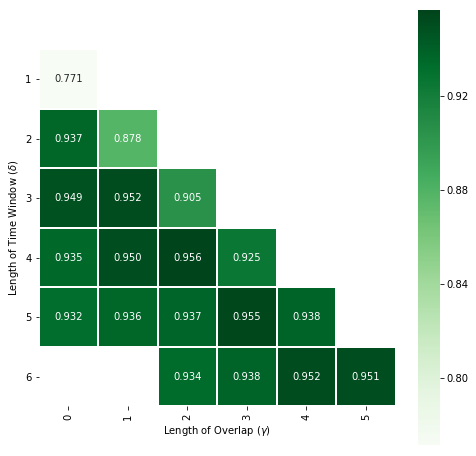

In [44]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp) #print("\nMAX:", max(correlations, key=lambda x:x['mean']))
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".eps")


#### Scores computation

In [45]:
score_venues = get_score_venues(field_name, best_parameters, __db_name, main_collection_name, experiment_collection_name)


In [46]:
print("Top Venues according to our method")
score_venues.sort_values(by="param", ascending=False)[["venue", "param", "custom_citescore"]][:20]

Top Venues according to our method


,venue,param,custom_citescore
0,kdd,7663.999997,4.644172
1,machine learning,7119.699973,4.881481
2,journal of machine learning research,7052.199975,6.422527
3,ieee trans. knowl. data eng,6651.199991,2.349465
4,cikm,6497.800009,2.983582
5,icdm,6413.399993,1.510526
6,sigir,6332.400000,5.120166
7,ieee trans. pattern anal. mach. intell,6207.900000,3.855319
8,www,5923.699988,7.032778
9,ijcai,5673.000006,1.657960


In [47]:
print("Top Venues according to our Impact Factor")
score_venues.sort_values(by="custom_citescore", ascending=False)[["venue", "custom_citescore", "param"]][:20]

Top Venues according to our Impact Factor


,venue,custom_citescore,param
118,neurocomputing,162.700000,NaN
115,pattern recognition,67.200000,48.100000
91,expert syst. appl,56.310714,935.999990
121,knowl.-based syst,51.400000,NaN
119,cvpr,51.325000,NaN
127,international journal of geographical informat...,11.900000,NaN
77,j. web sem,10.020000,1272.900004
106,ieee/acm trans. comput. biology bioinform,8.050000,266.200000
11,acm comput. surv,7.177966,5388.200027
126,ieee communications letters,7.100000,NaN


#### Correlations with other scores

Spearman correlation with custom Impact Factor: 0.5098457941824394


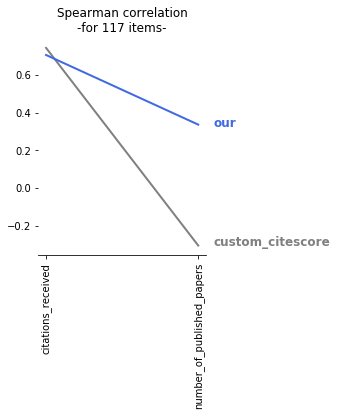

                      feature             score     value
0          citations_received  custom_citescore  0.743915
1          citations_received             param  0.706262
2  number_of_published_papers  custom_citescore -0.304478
3  number_of_published_papers             param  0.336856


In [48]:
print("Spearman correlation with custom Impact Factor:",
      score_venues.dropna()["param"].corr(score_venues.dropna()["custom_citescore"], method='spearman'))
res = []
for item_1 in ["citations_received", "number_of_published_papers"]:
    for item_2 in ["custom_citescore", "param"]:
        tmp_local = score_venues.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_venues.dropna()))
print(pd.DataFrame(res))

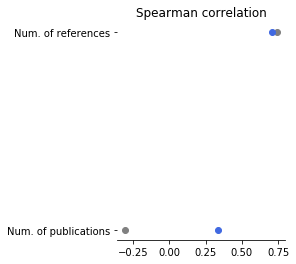

In [50]:
def get_correlations_dict(df):
    res = []
    ####
    item_1 = "citations_received"; item_2 = "custom_citescore"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of references", "score": "Impact Factor", "value": corr, "item": "Venues"}]
    ####
    item_1 = "citations_received"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of references", "score": "param", "value": corr, "item": "Venues"}]
    ####
    item_1 = "number_of_published_papers"; item_2 = "custom_citescore"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "Impact Factor", "value": corr, "item": "Venues"}]
    ####
    item_1 = "number_of_published_papers"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "param", "value": corr, "item": "Venues"}]
    return res

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict(score_venues)))
plot_correlations(pd.DataFrame(get_correlations_dict(score_venues)).sort_values(by="feature"))


### Authors

In [54]:
field_name = "authors"
iN_index_score = 10

list_of_items = [x['_id'] for x in list(client[__db_name][main_collection_name].aggregate([
    {'$project': {field_name: 1 }}, 
    {'$unwind': '$'+field_name}, 
    {"$match": {field_name: {'$exists': True, '$ne': None} }},
    {'$sortByCount': '$'+field_name },
    {'$match': {'count': {'$gte': 1}}}
]))]
print(len(list_of_items), field_name, "contained on dataset")

list_of_items = [x['author'] for x in list(list_of_authors(range_of_years=initial_years, local_collection=client[__db_name][main_collection_name]))]
print(len(list_of_items), "authors on dataset have published papers between", initial_years[0], "and", initial_years[1])

experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name


206795 authors contained on dataset
42638 authors on dataset have published papers between 2000 and 2004


'scipub_minimal_venus-experiment-2000_2004-2005_2014-authors'

In [55]:
list(client[__db_name][main_collection_name].aggregate([
    {'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]}}}, 
    {'$project': {field_name: 1 }}, 
    {'$unwind': '$'+field_name}, 
    {"$match": {field_name: {'$exists': True, '$ne': None} }},
    {'$sortByCount': '$'+field_name },
]))

[{'_id': 'Jiawei Han', 'count': 58},
 {'_id': 'Philip S. Yu', 'count': 54},
 {'_id': 'HongJiang Zhang', 'count': 54},
 {'_id': 'Wei-Ying Ma', 'count': 51},
 {'_id': 'Edwin R. Hancock', 'count': 38},
 {'_id': 'Abdul-Majid Wazwaz', 'count': 37},
 {'_id': 'Christos Faloutsos', 'count': 37},
 {'_id': 'Anil K. Jain', 'count': 37},
 {'_id': 'Xiaojing Yang', 'count': 35},
 {'_id': 'Elisa Bertino', 'count': 34},
 {'_id': 'Thomas S. Huang', 'count': 33},
 {'_id': 'Kian-Lee Tan', 'count': 33},
 {'_id': 'Yimin Wei', 'count': 33},
 {'_id': 'Qiang Yang 0001', 'count': 32},
 {'_id': 'Charu C. Aggarwal', 'count': 31},
 {'_id': 'Jian Pei', 'count': 29},
 {'_id': 'W. Neville Holmes', 'count': 29},
 {'_id': 'Bing Liu 0001', 'count': 29},
 {'_id': 'Wan-Tong Li', 'count': 29},
 {'_id': 'Hongjun Lu', 'count': 28},
 {'_id': 'Aidong Zhang', 'count': 28},
 {'_id': 'Ming-Syan Chen', 'count': 27},
 {'_id': 'Dimitrios Gunopulos', 'count': 27},
 {'_id': 'Dimitris Papadias', 'count': 27},
 {'_id': 'Johannes Gehrke

In [62]:
create_our_scores(field_name, list_of_items, __db_name, main_collection_name, experiment_collection_name, influence_years, max_time_window_size)


Documents in collection scipub_minimal_venus-experiment-2000_2004-2005_2014-authors: 0 

TW: 1 OV: 0 th: 0 - start @ Sat Feb  9 15:39:56 2019
TW: 2 OV: 0 th: 1 - start @ Sat Feb  9 15:39:56 2019
TW: 2 OV: 1 th: 2 - start @ Sat Feb  9 15:39:56 2019
TW: 3 OV: 0 th: 3 - start @ Sat Feb  9 15:39:56 2019
TW: 3 OV: 1 th: 4 - start @ Sat Feb  9 15:39:56 2019
TW: 3 OV: 2 th: 5 - start @ Sat Feb  9 15:39:56 2019
TW: 4 OV: 0 th: 6 - start @ Sat Feb  9 15:39:56 2019
TW: 4 OV: 1 th: 7 - start @ Sat Feb  9 15:39:56 2019
TW: 4 OV: 2 th: 8 - start @ Sat Feb  9 15:39:56 2019
TW: 4 OV: 3 th: 9 - start @ Sat Feb  9 15:39:56 2019
TW: 4 OV: 0 th: 6 - end @ Sat Feb  9 22:52:17 2019 - total time 7:12:21 - documents 42638 - scores: 14611
TW: 5 OV: 0 th: 6 - start @ Sat Feb  9 22:52:18 2019
TW: 1 OV: 0 th: 0 - end @ Sat Feb  9 23:33:00 2019 - total time 7:53:04 - documents 42638 - scores: 4799
TW: 5 OV: 1 th: 0 - start @ Sat Feb  9 23:33:01 2019
TW: 3 OV: 0 th: 3 - end @ Sat Feb  9 23:33:19 2019 - total time 

In [68]:
client[__db_name][experiment_collection_name].find_one({'_id': 'Jiawei Han-5-3'})

{'_id': 'Jiawei Han-5-3',
 'layer': [0, 1, 2, 3],
 'number_of_papers': [58, 725, 1402, 3432],
 'number_of_authors': [74, 1395, 3427, 7821],
 'number_of_new_authors': [0, 1352, 2569, 5841],
 'authors': 'Jiawei Han',
 'time_window_size': 5,
 'overlap': 3,
 'fit': {'number_of_authors': {'params': [5623.9999991207715,
    662.6666789810931],
   'stderr': [1268.4384901009516, 1637.5470862543777]},
  'number_of_new_authors': {'params': [4205.0000128498405, 806.6666569460504],
   'stderr': [944.5450254157971, 1219.4023813496372]},
  'number_of_papers': {'params': [2416.9999967184162, 386.6666653461011],
   'stderr': [586.0105397771467, 756.536347220572]}}}

#### Select parameters
Select parameters with higher correlation with the other ones

### Considering the 18254 items having at least one parameter

MAX: {'experiment': '5 - 3', 'mean': 0.8918061685942581, 'std': 0.0841574616683597, 'time_window_size': 5, 'overlap': 3}


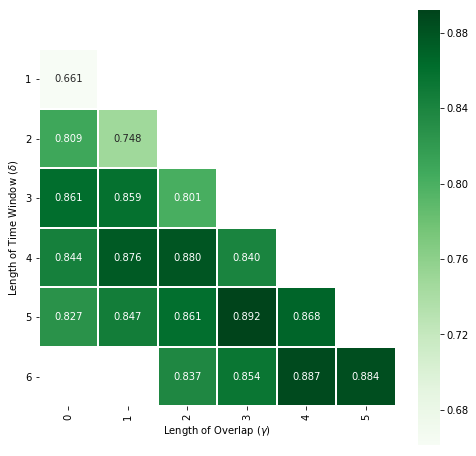

In [64]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp)
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".eps")


#### Scores computation

In [69]:
create_other_indexes_authors(field_name, list_of_items, iN_index_score, __db_name, main_collection_name, experiment_collection_name, initial_years, influence_years, max_time_window_size)


Start execution


Exiting Main Thread

 ### END of procedure! - Total Execution: 1:52:34


In [70]:
score_authors = get_score_authors(field_name, best_parameters, iN_index_score, __db_name, main_collection_name, experiment_collection_name)


In [71]:
print("Top authors, over", len(score_authors.dropna()), "authors, according to our method")
score_authors.sort_values(by=["param","number_of_papers_local"], ascending=[False, True])[:60]

Top authors, over 16245 authors, according to our method


,author,g_index,g_index_local,h_index,h_index_local,i10_index,i10_index_local,m_index,m_index_local,overlap,param,time_window_size,range_of_years,year_first,year_last,range_of_years_local,year_first_local,year_last_local,number_of_papers,number_of_papers_local
0,Michael I. Jordan,48,46,17,16,24,22,39.0,37.0,3,4966.999991,5,24,1991,2015,14,2000,2014,72,57
1,Pedro Domingos,36,33,18,16,25,22,32.5,32.5,3,4432.499974,5,17,1995,2012,12,2000,2012,43,38
2,Wei-Ying Ma,40,37,25,25,60,57,44.0,38.0,3,4271.000015,5,19,1996,2015,13,2001,2014,149,145
3,Jiawei Han,54,50,32,30,114,107,51.0,40.5,3,4205.000013,5,26,1989,2015,14,2000,2014,353,327
4,Christos Faloutsos,45,38,28,26,55,46,46.0,42.0,3,4116.999958,5,30,1985,2015,14,2000,2014,219,193
5,George Karypis,33,28,14,14,26,23,39.5,30.5,3,4066.000000,5,17,1998,2015,13,2000,2013,52,48
6,ChengXiang Zhai,45,45,25,25,43,43,50.0,50.0,3,3887.499990,5,13,2001,2014,13,2001,2014,115,115
7,Thorsten Joachims,40,35,16,16,19,19,81.0,81.0,3,3868.499995,5,17,1998,2015,12,2002,2014,40,36
8,Raymond J. Mooney,29,27,14,13,20,17,40.5,26.0,3,3795.999984,5,26,1985,2011,10,2001,2011,55,36
9,Andrew Y. Ng,38,30,13,12,16,14,20.0,22.0,3,3743.500014,5,16,1997,2013,12,2001,2013,40,38


In [72]:
print("Top authors, over", len(score_authors.dropna()), "authors, according to h-index")
score_authors.sort_values(by=["h_index_local","number_of_papers_local"], ascending=[False, True])[:60]

Top authors, over 16245 authors, according to h-index


,author,g_index,g_index_local,h_index,h_index_local,i10_index,i10_index_local,m_index,m_index_local,overlap,param,time_window_size,range_of_years,year_first,year_last,range_of_years_local,year_first_local,year_last_local,number_of_papers,number_of_papers_local
3,Jiawei Han,54,50,32,30,114,107,51.0,40.5,3,4205.000013,5,26,1989,2015,14,2000,2014,353,327
4,Christos Faloutsos,45,38,28,26,55,46,46.0,42.0,3,4116.999958,5,30,1985,2015,14,2000,2014,219,193
6,ChengXiang Zhai,45,45,25,25,43,43,50.0,50.0,3,3887.499990,5,13,2001,2014,13,2001,2014,115,115
2,Wei-Ying Ma,40,37,25,25,60,57,44.0,38.0,3,4271.000015,5,19,1996,2015,13,2001,2014,149,145
29,Philip S. Yu,44,40,26,25,88,80,49.0,44.0,3,3034.500000,5,28,1987,2015,14,2000,2014,363,326
49,W. Bruce Croft,41,39,26,24,50,45,48.0,46.5,3,2630.500008,5,36,1978,2014,14,2000,2014,132,110
133,Alon Y. Halevy,35,35,22,22,35,35,40.0,40.0,3,1973.500008,5,15,2000,2015,14,2000,2014,73,72
92,Jian Pei,37,37,22,22,42,42,42.5,42.5,3,2245.999994,5,15,2000,2015,14,2000,2014,153,151
369,Qiang Yang 0001,35,35,21,21,49,49,30.0,30.0,3,1276.000001,5,26,1989,2015,14,2000,2014,201,190
84,Eamonn J. Keogh,33,33,20,20,31,31,43.5,43.5,3,2350.500012,5,18,1997,2015,14,2000,2014,96,93


Spearman correlation with h-index_local: 0.45071009985214533


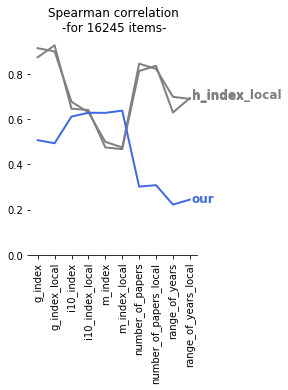

                   feature          score     value
0           range_of_years  h_index_local  0.628437
1           range_of_years        h_index  0.697909
2           range_of_years          param  0.221776
3         number_of_papers  h_index_local  0.811795
4         number_of_papers        h_index  0.844186
5         number_of_papers          param  0.301200
6                  g_index  h_index_local  0.872187
7                  g_index        h_index  0.912640
8                  g_index          param  0.506188
9                  m_index  h_index_local  0.474286
10                 m_index        h_index  0.499004
11                 m_index          param  0.626842
12               i10_index  h_index_local  0.645194
13               i10_index        h_index  0.675824
14               i10_index          param  0.610416
15    range_of_years_local  h_index_local  0.692261
16    range_of_years_local        h_index  0.688452
17    range_of_years_local          param  0.243743
18  number_o

In [73]:
print("Spearman correlation with h-index_local:",
      score_authors.dropna()["param"].corr(score_authors.dropna()["h_index_local"], method='spearman'))

res = []
for item_1 in ["range_of_years", "number_of_papers", "g_index", "m_index", "i"+str(iN_index_score)+"_index", "range_of_years_local", "number_of_papers_local", "g_index_local", "m_index_local", "i"+str(iN_index_score)+"_index_local"]:#["year_first", "year_first_local", ]
    for item_2 in ["h_index_local", "h_index", "param"]:
        tmp_local = score_authors.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_authors.dropna()))
print(pd.DataFrame(res))

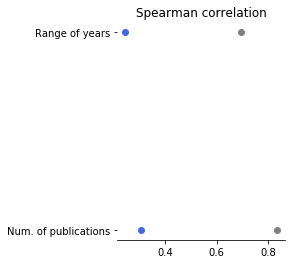

In [74]:
def get_correlations_dict(df):
    res = []
    ####
    item_1 = "range_of_years_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "range_of_years_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "param", "value": corr, "item": "Authors"}]
    ####
    item_1 = "number_of_papers_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "number_of_papers_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "param", "value": corr, "item": "Authors"}]
    return res

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict(score_authors)))
plot_correlations(pd.DataFrame(get_correlations_dict(score_authors)).sort_values(by="feature"))

### Publications

In [78]:
field_name = "acm_id"

list_of_items = [x['acm_id'] for x in list(client[__db_name][main_collection_name].find({'year': {'$gte': initial_years[0], '$lte': initial_years[1]}}, {'acm_id': 1} ))]
print(len(list_of_items), "papers published between", initial_years[0], "and", initial_years[1], "on dataset")
experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name

29177 papers published between 2000 and 2004 on dataset


'scipub_minimal_venus-experiment-2000_2004-2005_2014-acm_id'

In [79]:
list(client[__db_name][main_collection_name].aggregate([
    {'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]}}}, 
    {'$project': {field_name: 1, 'acm_cited_by': '$acm_cited_by.acm_id' }}, 
    {'$unwind': '$acm_cited_by'}, 
    {'$sortByCount': '$'+field_name },
    {'$limit': 10}
]))

[{'_id': '5390958920f70186a0deea5b', 'count': 1122},
 {'_id': '53908b4920f70186a0dbc3df', 'count': 564},
 {'_id': '539088b820f70186a0d8f6a0', 'count': 547},
 {'_id': '5390881720f70186a0d80bfc', 'count': 490},
 {'_id': '5390958920f70186a0deea74', 'count': 473},
 {'_id': '5390880720f70186a0d7a7be', 'count': 446},
 {'_id': '5390893e20f70186a0d9292c', 'count': 441},
 {'_id': '539095ba20f70186a0df1b2f', 'count': 370},
 {'_id': '53908b9320f70186a0dc040d', 'count': 346},
 {'_id': '53908b4920f70186a0dbb0b1', 'count': 339}]

In [84]:
create_our_scores(field_name, list_of_items, __db_name, main_collection_name, experiment_collection_name, influence_years, max_time_window_size)


Documents in collection scipub_minimal_venus-experiment-2000_2004-2005_2014-acm_id: 0 

TW: 1 OV: 0 th: 0 - start @ Sun Feb 10 15:08:22 2019
TW: 2 OV: 0 th: 1 - start @ Sun Feb 10 15:08:22 2019
TW: 2 OV: 1 th: 2 - start @ Sun Feb 10 15:08:22 2019
TW: 3 OV: 0 th: 3 - start @ Sun Feb 10 15:08:22 2019
TW: 3 OV: 1 th: 4 - start @ Sun Feb 10 15:08:22 2019
TW: 3 OV: 2 th: 5 - start @ Sun Feb 10 15:08:22 2019
TW: 4 OV: 0 th: 6 - start @ Sun Feb 10 15:08:22 2019
TW: 4 OV: 1 th: 7 - start @ Sun Feb 10 15:08:22 2019
TW: 4 OV: 2 th: 8 - start @ Sun Feb 10 15:08:22 2019
TW: 4 OV: 3 th: 9 - start @ Sun Feb 10 15:08:22 2019
TW: 4 OV: 0 th: 6 - end @ Sun Feb 10 19:34:25 2019 - total time 4:26:03 - documents 29177 - scores: 9029
TW: 5 OV: 0 th: 6 - start @ Sun Feb 10 19:34:26 2019
TW: 1 OV: 0 th: 0 - end @ Sun Feb 10 19:52:05 2019 - total time 4:43:43 - documents 29177 - scores: 2701
TW: 5 OV: 1 th: 0 - start @ Sun Feb 10 19:52:05 2019
TW: 3 OV: 0 th: 3 - end @ Sun Feb 10 20:00:48 2019 - total time 4:

In [85]:
client[__db_name][experiment_collection_name].find_one({'_id': '53908b4920f70186a0dbc3df-5-3'})

{'_id': '53908b4920f70186a0dbc3df-5-3',
 'layer': [0, 1, 2, 3],
 'number_of_papers': [1, 212, 1168, 3218],
 'number_of_authors': [1, 491, 2392, 6909],
 'number_of_new_authors': [0, 490, 2007, 5109],
 'acm_id': '53908b4920f70186a0dbc3df',
 'time_window_size': 5,
 'overlap': 3,
 'fit': {'number_of_authors': {'params': [4650.499990331459,
    -261.83332261685734],
   'stderr': [1303.9457132386178, 1683.38659549465]},
  'number_of_new_authors': {'params': [3558.0000045619718, -27.00000449102572],
   'stderr': [895.4701421466515, 1156.0470644398383]},
  'number_of_papers': {'params': [2193.0000100515795, -129.66668341929852],
   'stderr': [591.7840424441657, 763.989896345065]}}}

#### Select parameters
Select parameters with higher correlation with the other ones

### Considering the 11417 items having at least one parameter

MAX: {'experiment': '5 - 3', 'mean': 0.8759015231062612, 'std': 0.09818075052789958, 'time_window_size': 5, 'overlap': 3}


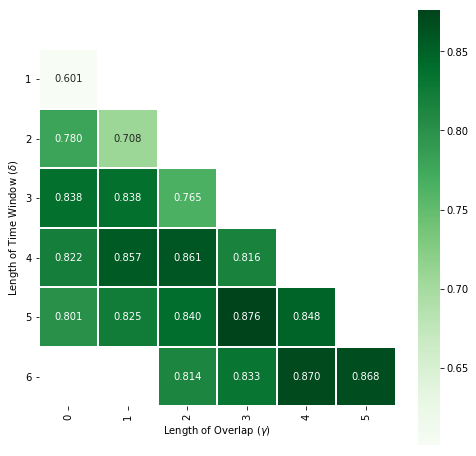

In [87]:
correlations = TW_correlations("acm_id", client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp)
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".eps")


#### Scores computation

In [88]:
score_papers = get_score_papers("acm_id", best_parameters, __db_name, main_collection_name, experiment_collection_name)


In [93]:
print("Top Documents by our method")
score_papers[["_id","param"]].merge(pd.DataFrame(list(client[config.__db_name]["dblp_papers"].aggregate([{'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]} }},{'$project': { '_id': 0, 'acm_id': 1, 'title': 1, 'authors': 1 }}]))), left_on="_id", right_on="acm_id").sort_values(by="param", ascending=False)[["acm_id", "title", "authors", "param"]][:40]


Top Documents by our method


,acm_id,title,authors,param
0,53908b4920f70186a0dbc3df,Optimizing search engines using clickthrough d...,[Thorsten Joachims],3558.000005
1,5390958920f70186a0deea5b,Latent Dirichlet Allocation.,"[David M. Blei, Andrew Y. Ng, Michael I. Jordan]",3097.499997
2,5390880720f70186a0d78970,Text Classification from Labeled and Unlabeled...,"[Kamal Nigam, Andrew McCallum, Sebastian Thrun...",3074.999995
3,5390881720f70186a0d80bfc,Machine learning in automated text categorizat...,[Fabrizio Sebastiani 0001],2778.500001
4,5390880220f70186a0d781e4,IR evaluation methods for retrieving highly re...,"[Kalervo Järvelin, Jaana Kekäläinen]",2482.500015
5,539096cb20f70186a0df79e8,Web-scale information extraction in knowitall:...,"[Oren Etzioni, Michael J. Cafarella, Doug Down...",2378.499997
6,5390972920f70186a0dfa5ea,RCV1: A New Benchmark Collection for Text Cate...,"[David D. Lewis, Yiming Yang, Tony G. Rose, Fa...",2304.499999
7,5390958920f70186a0deea74,An Introduction to Variable and Feature Select...,"[Isabelle Guyon, André Elisseeff]",2286.499993
8,5390881720f70186a0d7fe20,"Document Language Models, Query Models, and Ri...","[John D. Lafferty, ChengXiang Zhai]",2202.000009
9,539095ba20f70186a0df1b31,Latent semantic models for collaborative filte...,[Thomas Hofmann],1950.499991


In [96]:
print("Top Documents by number of citations received")
score_papers[["_id","number_of_citations"]].merge(pd.DataFrame(list(client[config.__db_name]["dblp_papers"].aggregate([{'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]} }},{'$project': { '_id': 0, 'acm_id': 1, 'title': 1, 'authors': 1 }}]))), left_on="_id", right_on="acm_id").sort_values(by="number_of_citations", ascending=False)[["acm_id", "title", "authors", "number_of_citations"]][:40]


Top Documents by number of citations received


,acm_id,title,authors,number_of_citations
1,5390958920f70186a0deea5b,Latent Dirichlet Allocation.,"[David M. Blei, Andrew Y. Ng, Michael I. Jordan]",1122.0
0,53908b4920f70186a0dbc3df,Optimizing search engines using clickthrough d...,[Thorsten Joachims],564.0
15,539088b820f70186a0d8f6a0,Random Forests.,[Leo Breiman],547.0
3,5390881720f70186a0d80bfc,Machine learning in automated text categorizat...,[Fabrizio Sebastiani 0001],490.0
7,5390958920f70186a0deea74,An Introduction to Variable and Feature Select...,"[Isabelle Guyon, André Elisseeff]",473.0
12,5390880720f70186a0d7a7be,Content-Based Image Retrieval at the End of th...,"[Arnold W. M. Smeulders, Marcel Worring, Simon...",446.0
28,5390893e20f70186a0d9292c,Cumulated gain-based evaluation of IR techniques.,"[Kalervo Järvelin, Jaana Kekäläinen]",441.0
11,539095ba20f70186a0df1b2f,Evaluating collaborative filtering recommender...,"[Jonathan L. Herlocker, Joseph A. Konstan, Lor...",370.0
10,53908b9320f70186a0dc040d,Laplacian Eigenmaps for Dimensionality Reducti...,"[Mikhail Belkin, Partha Niyogi]",346.0
53,53908b4920f70186a0dbb0b1,A survey of approaches to automatic schema mat...,"[Erhard Rahm, Philip A. Bernstein]",339.0


Spearman correlation with number of references: 0.646562992536473


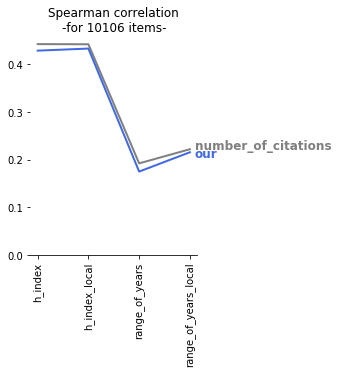

                feature                score     value
0         h_index_local  number_of_citations  0.442061
1         h_index_local                param  0.433028
2               h_index  number_of_citations  0.442382
3               h_index                param  0.428691
4  range_of_years_local  number_of_citations  0.222053
5  range_of_years_local                param  0.215685
6        range_of_years  number_of_citations  0.192455
7        range_of_years                param  0.175240


In [97]:
print("Spearman correlation with number of references:",
      score_papers.dropna()["param"].corr(score_papers.dropna()["number_of_citations"], method='spearman'))
res = []
for item_1 in ["h_index_local", "h_index", "range_of_years_local", "range_of_years"]:
    for item_2 in ["number_of_citations", "param"]:
        tmp_local = score_papers.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_papers.dropna()))
print(pd.DataFrame(res))


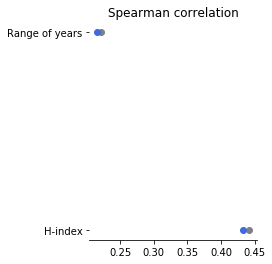

In [99]:
def get_correlations_dict(df):
    res = []
    ####
    item_1 = "range_of_years_local"; item_2 = "number_of_citations"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "h-index", "value": corr, "item": "Documents"}]
    ####
    item_1 = "range_of_years_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "param", "value": corr, "item": "Documents"}]
    ####
    item_1 = "h_index_local"; item_2 = "number_of_citations"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "H-index", "score": "h-index", "value": corr, "item": "Documents"}]
    ####
    item_1 = "h_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "H-index", "score": "param", "value": corr, "item": "Documents"}]
    return res

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict(score_papers)))
plot_correlations(pd.DataFrame(get_correlations_dict(score_papers)).sort_values(by="feature"))

## Topics

In [150]:
topic_threshold = 0.2

In [131]:
client[__db_name][main_collection_name].find_one({"topics": {"$exists": 1}})

{'_id': '539087fe20f70186a0d74dd3',
 'acm_id': '539087fe20f70186a0d74dd3',
 'title': 'Filtering Memory References to Increase Energy Efficiency.',
 'authors': ['Johnson Kin', 'Munish Gupta', 'William H. Mangione-Smith'],
 'year': 2000,
 'venue': 'ieee trans. computers',
 'acm_cited_by': [{'acm_id': '539089bb20f70186a0d99782',
   'authors': ['Trevor N. Mudge'],
   'year': 2001},
  {'acm_id': '5390981d20f70186a0e051b9',
   'authors': ['Murali Jayapala',
    'Francisco Barat',
    'Tom Vander Aa',
    'Francky Catthoor',
    'Henk Corporaal',
    'Geert Deconinck'],
   'year': 2005},
  {'acm_id': '5390958a20f70186a0deff8d',
   'authors': ['Lorenzo Salvemini',
    'Mariagiovanna Sami',
    'Donatella Sciuto',
    'Cristina Silvano',
    'Vittorio Zaccaria',
    'Roberto Zafalon'],
   'year': 2003}],
 'topics': [{'id': 5, 'weight': 0.0105723147},
  {'id': 10, 'weight': 0.0136350755},
  {'id': 14, 'weight': 0.0403913599},
  {'id': 17, 'weight': 0.0130753038},
  {'id': 18, 'weight': 0.0102054

In [136]:
field_name = "topics"

list_of_items= [x['_id'] for x in list(client[__db_name][main_collection_name].aggregate([
    {'$project': {'_id': 0, 'acm_id': 1, field_name: 1 }}, 
    {'$unwind': '$'+field_name }, 
    {'$project': {'id': '$'+field_name+".id"}}, 
    {'$group': { '_id': '$id'}}
]))]
print(len(list_of_items), "topics are contained on dataset")
experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name

50 topics are contained on dataset


'scipub_minimal_venus-experiment-2000_2004-2005_2014-topics'

In [137]:
list(client[__db_name][main_collection_name].aggregate([
    {'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]}}}, 
    {'$project': {'_id': 0, 'acm_id': 1, field_name: 1 }}, 
    {'$unwind': '$'+field_name }, 
    {'$project': {'id': '$'+field_name+".id"}}, 
    {'$sortByCount': '$id'},
    {'$limit': 10}
]))

[{'_id': 42, 'count': 7996},
 {'_id': 24, 'count': 7821},
 {'_id': 7, 'count': 7667},
 {'_id': 6, 'count': 7490},
 {'_id': 19, 'count': 7321},
 {'_id': 31, 'count': 7316},
 {'_id': 36, 'count': 7261},
 {'_id': 43, 'count': 7166},
 {'_id': 12, 'count': 6961},
 {'_id': 48, 'count': 6847}]

In [142]:
list(list_of_papers([42], 'topics.id', range_of_years=initial_years, local_collection=client[__db_name][main_collection_name]))


[{'_id': '539087fe20f70186a0d74dd3',
  'acm_id': '539087fe20f70186a0d74dd3',
  'title': 'Filtering Memory References to Increase Energy Efficiency.',
  'authors': ['Johnson Kin', 'Munish Gupta', 'William H. Mangione-Smith'],
  'year': 2000,
  'venue': 'ieee trans. computers',
  'acm_cited_by': [{'acm_id': '539089bb20f70186a0d99782',
    'authors': ['Trevor N. Mudge'],
    'year': 2001},
   {'acm_id': '5390981d20f70186a0e051b9',
    'authors': ['Murali Jayapala',
     'Francisco Barat',
     'Tom Vander Aa',
     'Francky Catthoor',
     'Henk Corporaal',
     'Geert Deconinck'],
    'year': 2005},
   {'acm_id': '5390958a20f70186a0deff8d',
    'authors': ['Lorenzo Salvemini',
     'Mariagiovanna Sami',
     'Donatella Sciuto',
     'Cristina Silvano',
     'Vittorio Zaccaria',
     'Roberto Zafalon'],
    'year': 2003}],
  'topics': [{'id': 5, 'weight': 0.0105723147},
   {'id': 10, 'weight': 0.0136350755},
   {'id': 14, 'weight': 0.0403913599},
   {'id': 17, 'weight': 0.0130753038},
   

In [154]:
create_our_scores(field_name, list_of_items, __db_name, main_collection_name, experiment_collection_name, influence_years, max_time_window_size, mongo_field_name=field_name+'.id', topic_threshold=topic_threshold)


Documents in collection scipub_minimal_venus-experiment-2000_2004-2005_2014-topics: 0 

TW: 1 OV: 0 th: 0 - start @ Wed Feb 13 09:22:07 2019
TW: 2 OV: 0 th: 1 - start @ Wed Feb 13 09:22:07 2019
TW: 2 OV: 1 th: 2 - start @ Wed Feb 13 09:22:07 2019
TW: 3 OV: 0 th: 3 - start @ Wed Feb 13 09:22:07 2019
TW: 3 OV: 1 th: 4 - start @ Wed Feb 13 09:22:07 2019
TW: 3 OV: 2 th: 5 - start @ Wed Feb 13 09:22:07 2019
TW: 4 OV: 0 th: 6 - start @ Wed Feb 13 09:22:07 2019
TW: 4 OV: 1 th: 7 - start @ Wed Feb 13 09:22:07 2019
TW: 4 OV: 2 th: 8 - start @ Wed Feb 13 09:22:07 2019
TW: 4 OV: 3 th: 9 - start @ Wed Feb 13 09:22:07 2019
TW: 4 OV: 0 th: 6 - end @ Wed Feb 13 09:28:44 2019 - total time 0:06:37 - documents 50 - scores: 50
TW: 5 OV: 0 th: 6 - start @ Wed Feb 13 09:28:44 2019
TW: 1 OV: 0 th: 0 - end @ Wed Feb 13 09:29:17 2019 - total time 0:07:10 - documents 50 - scores: 50
TW: 5 OV: 1 th: 0 - start @ Wed Feb 13 09:29:17 2019
TW: 3 OV: 0 th: 3 - end @ Wed Feb 13 09:36:09 2019 - total time 0:14:02 - do

In [156]:
client[__db_name][experiment_collection_name].find_one({'_id': '19-5-3'})

{'_id': '19-5-3',
 'layer': [0, 1, 2, 3],
 'number_of_papers': [2170, 6174, 9067, 9835],
 'number_of_authors': [3968, 10378, 18293, 23430],
 'number_of_new_authors': [0, 8770, 11546, 12241],
 'topics': 19,
 'time_window_size': 5,
 'overlap': 3,
 'fit': {'number_of_authors': {'params': [20861.500005488047,
    9521.83332418659],
   'stderr': [1482.9241751524173, 1914.4468531746109]},
  'number_of_new_authors': {'params': [11893.5, 8654.166666666666],
   'stderr': [200.62921777032778, 259.01120566042715]},
  'number_of_papers': {'params': [9451.0, 6046.0],
   'stderr': [221.7025032808031, 286.2167018002403]}}}

#### Select parameters
Select parameters with higher correlation with the other ones

### Considering the 50 items having at least one parameter

MAX: {'experiment': '5 - 3', 'mean': 0.972095504868614, 'std': 0.03126463415807723, 'time_window_size': 5, 'overlap': 3}


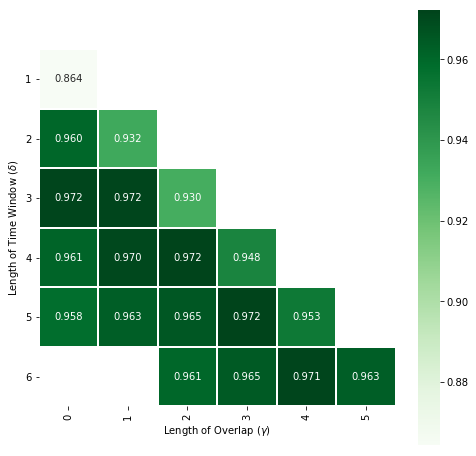

In [157]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp) #print("\nMAX:", max(correlations, key=lambda x:x['mean']))
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".eps")


#### Scores computation

In [224]:
create_other_indexes_topics(field_name, list_of_items, __db_name, main_collection_name, experiment_collection_name, influence_years, max_time_window_size, topic_threshold)


Topic: 11 th: 0 - start @ Wed Feb 13 15:57:55 2019
Topic: 21 th: 1 - start @ Wed Feb 13 15:57:55 2019
Topic: 15 th: 2 - start @ Wed Feb 13 15:57:55 2019
Topic: 28 th: 3 - start @ Wed Feb 13 15:57:55 2019
Topic: 20 th: 4 - start @ Wed Feb 13 15:57:55 2019
Topic: 9 th: 5 - start @ Wed Feb 13 15:57:55 2019
Topic: 31 th: 6 - start @ Wed Feb 13 15:57:55 2019
Topic: 1 th: 7 - start @ Wed Feb 13 15:57:55 2019
Topic: 29 th: 8 - start @ Wed Feb 13 15:57:55 2019
Topic: 6 th: 9 - start @ Wed Feb 13 15:57:55 2019
Topic: 20 th: 4 - end @ Wed Feb 13 15:58:01 2019 - total time 0:00:06
Topic: 49 th: 4 - start @ Wed Feb 13 15:58:01 2019
Topic: 11 th: 0 - end @ Wed Feb 13 15:58:01 2019 - total time 0:00:06
Topic: 17 th: 0 - start @ Wed Feb 13 15:58:01 2019
Topic: 21 th: 1 - end @ Wed Feb 13 15:58:02 2019 - total time 0:00:07
Topic: 16 th: 1 - start @ Wed Feb 13 15:58:02 2019
Topic: 1 th: 7 - end @ Wed Feb 13 15:58:02 2019 - total time 0:00:07
Topic: 47 th: 7 - start @ Wed Feb 13 15:58:02 2019
Topic: 28 

In [225]:
client[__db_name][experiment_collection_name].find_one({'_id': '19-5-3'})

{'_id': '19-5-3',
 'layer': [0, 1, 2, 3],
 'number_of_papers': [2170, 6174, 9067, 9835],
 'number_of_authors': [3968, 10378, 18293, 23430],
 'number_of_new_authors': [0, 8770, 11546, 12241],
 'topics': 19,
 'time_window_size': 5,
 'overlap': 3,
 'fit': {'number_of_authors': {'params': [20861.500005488047,
    9521.83332418659],
   'stderr': [1482.9241751524173, 1914.4468531746109]},
  'number_of_new_authors': {'params': [11893.5, 8654.166666666666],
   'stderr': [200.62921777032778, 259.01120566042715]},
  'number_of_papers': {'params': [9451.0, 6046.0],
   'stderr': [221.7025032808031, 286.2167018002403]}},
 'diffusion-fit': {'number_of_authors': {'params': [3588.375758277687,
    961.1090922587105],
   'stderr': [99.33891513253113, 530.3246796051194]},
  'number_of_new_authors': {'params': [2078.896966981106, 1103.3636394335513],
   'stderr': [39.01980760265193, 208.30877525527072]},
  'number_of_papers': {'params': [1386.6727239303175, 641.0727484413212],
   'stderr': [25.9187425878

In [227]:
score_topics = get_score_topics(field_name, best_parameters, __db_name, main_collection_name, experiment_collection_name)


In [228]:
print("Top Topics according to our method")
score_topics.sort_values(by="param", ascending=False)[:25]


Top Topics according to our method


,topics,param,citations_received,publications_initial,publications_other,diffusion
0,19,11893.500000,21612,2170,13231,2078.896967
1,42,10793.999981,8265,2097,7913,1580.454545
2,36,9356.000008,4707,1212,6833,1407.248484
3,43,9287.999992,15268,2471,8969,1276.666666
4,26,8972.000016,14648,1294,6874,946.048486
5,41,8050.499986,8106,1034,3413,548.406061
6,7,8027.000010,4053,1240,4072,726.333334
7,6,7825.499964,3993,1291,4423,960.836363
8,12,7804.000006,2812,827,3936,857.406061
9,46,7771.999994,3679,271,1073,246.406060


In [230]:
print("Top Topics according diffusion")
score_topics.sort_values(by="diffusion", ascending=False)[:25]


Top Topics according diffusion


,topics,param,citations_received,publications_initial,publications_other,diffusion
0,19,11893.500000,21612,2170,13231,2078.896967
1,42,10793.999981,8265,2097,7913,1580.454545
2,36,9356.000008,4707,1212,6833,1407.248484
15,48,6770.500006,7884,2567,8646,1335.381820
3,43,9287.999992,15268,2471,8969,1276.666666
22,10,5525.499990,2813,1652,4724,1115.654544
13,15,7005.000008,2853,619,3682,1026.078788
33,14,3413.999998,1770,1181,4000,996.187880
7,6,7825.499964,3993,1291,4423,960.836363
4,26,8972.000016,14648,1294,6874,946.048486


Spearman correlation with diffusion: 0.7515486194477791


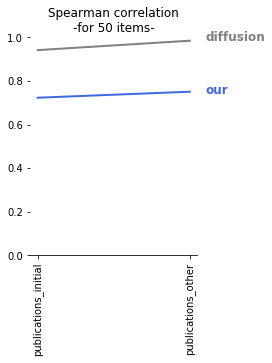

                feature      score     value
0  publications_initial  diffusion  0.941705
1  publications_initial      param  0.723217
2    publications_other  diffusion  0.984826
3    publications_other      param  0.750780


In [232]:
print("Spearman correlation with diffusion:",
      score_topics.dropna()["param"].corr(score_topics.dropna()["diffusion"], method='spearman'))
res = []
for item_1 in ["publications_initial", "publications_other"]:
    for item_2 in ["diffusion", "param"]:
        tmp_local = score_topics.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_topics.dropna()))
print(pd.DataFrame(res))


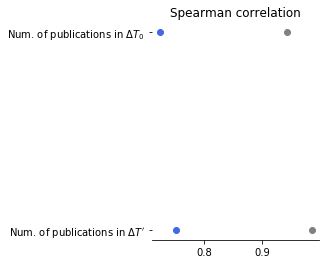

In [235]:
def get_correlations_dict(df):
    res = []
    ####
    item_1 = "publications_initial"; item_2 = "diffusion" #"citations_received"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T_0$", "score": "Num. of references", "value": corr, "item": "Topics"}]
    ####
    item_1 = "publications_initial"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T_0$", "score": "param", "value": corr, "item": "Topics"}]
    ####
    item_1 = "publications_other"; item_2 = "diffusion" #"citations_received"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T'$", "score": "Num. of references", "value": corr, "item": "Topics"}]
    ####
    item_1 = "publications_other"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T'$", "score": "param", "value": corr, "item": "Topics"}]
    return res

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict(score_topics)))
plot_correlations(pd.DataFrame(get_correlations_dict(score_topics)).sort_values(by="feature"))


Spearman correlation with number of references: 0.8134851137455601


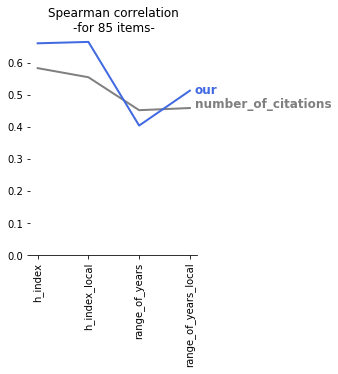

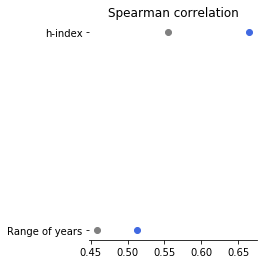

,feature,score,value
0,h_index_local,number_of_citations,0.554668
1,h_index_local,param,0.664786
2,h_index,number_of_citations,0.583025
3,h_index,param,0.660488
4,range_of_years_local,number_of_citations,0.458735
5,range_of_years_local,param,0.512868
6,range_of_years,number_of_citations,0.451959
7,range_of_years,param,0.404033


In [255]:
def get_correlations_dict_papers(df):
    res = []
    ####
    item_1 = "range_of_years_local"; item_2 = "number_of_citations"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "h-index", "value": corr, "item": "Documents"}]
    ####
    item_1 = "range_of_years_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "param", "value": corr, "item": "Documents"}]
    ####
    item_1 = "h_index_local"; item_2 = "number_of_citations"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "h-index", "score": "h-index", "value": corr, "item": "Documents"}]
    ####
    item_1 = "h_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "h-index", "score": "param", "value": corr, "item": "Documents"}]
    return res

print("Spearman correlation with number of references:",
      score_surveys.dropna()["param"].corr(score_surveys.dropna()["number_of_citations"], method='spearman'))
res = []
for item_1 in ["h_index_local", "h_index", "range_of_years_local", "range_of_years"]:#["year_first", "year_first_local", ]
    for item_2 in ["number_of_citations", "param"]:
        tmp_local = score_surveys.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_surveys.dropna()))
plot_correlations(pd.DataFrame(get_correlations_dict_papers(score_surveys)).sort_values(by="feature"))

pd.DataFrame(res)

### Analysis on surveys

In [319]:
from scipy.stats import ks_2samp
from matplotlib.ticker import FuncFormatter


In [349]:
score_surveys = score_papers[(score_papers["title"].str.contains("survey", case=False)) | (score_papers["title"].str.contains("review", case=False)) | (score_papers["title"].str.contains("state of the art", case=False)) | (score_papers["title"].str.contains("state-of-the-art", case=False))].sort_values(by="param", ascending=False)
score_no_surveys = score_papers[~(score_papers["title"].str.contains("survey", case=False)) & ~(score_papers["title"].str.contains("review", case=False)) & ~(score_papers["title"].str.contains("state of the art", case=False)) & ~(score_papers["title"].str.contains("state-of-the-art", case=False))].sort_values(by="param", ascending=False)

print(len(score_surveys), "surveys found (over", len(score_papers), "papers)")
print(len(score_no_surveys), "not surveys found (over", len(score_papers), "papers)")
score_surveys[:10]


181 surveys found (over 29177 papers)
28996 not surveys found (over 29177 papers)


,_id,title,param,number_of_citations,range_of_years,range_of_years_local,h_index,h_index_local
19,539087fe20f70186a0d75034,Statistical Pattern Recognition: A Review.,1735.000002,285.0,40.0,14.0,24.0,19.0
53,53908b4920f70186a0dbb0b1,A survey of approaches to automatic schema mat...,1406.499999,339.0,40.0,14.0,16.0,12.0
92,5390958a20f70186a0df0383,Face recognition: A literature survey.,1147.000000,232.0,42.0,14.0,9.0,8.0
138,53908b4920f70186a0dbc462,Mining the peanut gallery: opinion extraction ...,971.999997,116.0,10.0,10.0,11.0,9.0
164,5390962020f70186a0df41b0,A survey on the use of relevance feedback for ...,913.999992,51.0,17.0,14.0,8.0,8.0
237,5390972920f70186a0dfacfc,Subspace clustering for high dimensional data:...,786.500003,86.0,20.0,14.0,17.0,15.0
259,5390972920f70186a0dfbe12,Mining and summarizing customer reviews.,764.499998,206.0,19.0,14.0,17.0,16.0
278,53908b4920f70186a0dbc3dc,On the need for time series data mining benchm...,738.499998,71.0,18.0,14.0,20.0,20.0
295,53908b4920f70186a0dbb0ae,Answering queries using views: A survey.,726.000000,177.0,15.0,14.0,22.0,22.0
332,5390881720f70186a0d80cd8,Detecting Faces in Images: A Survey.,693.500002,100.0,36.0,14.0,11.0,7.0


In [358]:
def plot_distributions(distributions, labels, bins, x_label, filename=""):
    sns.set(font_scale=1.2, style="white")
    ax = 0
    for distribution, label, bin_ in zip(distributions, labels, bins):
        ax = sns.distplot(distribution, kde=False, norm_hist=True, label=label, bins=bin_)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax.set_ylabel("Percentage of documents")
    ax.set_xlabel(x_label)
    plt.legend()
    if filename!= "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    return


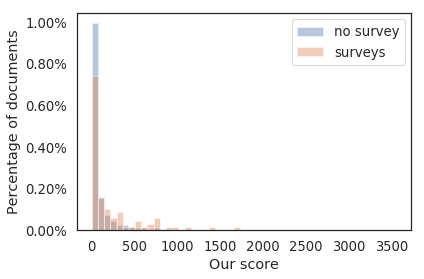

Ks_2sampResult(statistic=0.2123511520044331, pvalue=0.0002734273771975889)

In [359]:
plot_distributions([score_no_surveys.dropna()["param"], score_surveys.dropna()["param"]], ["no survey", "surveys"], [50, 24], "Our score", filename=RESULTS_DIR+"/documents_distribution-our.jpg")
ks_2samp(score_no_surveys.dropna()["param"], score_surveys.dropna()["param"])


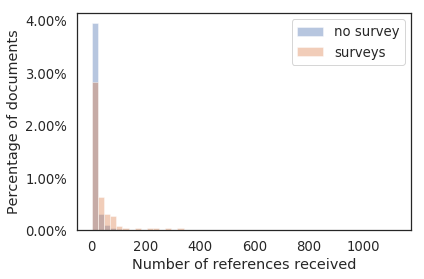

Ks_2sampResult(statistic=0.2960582898072147, pvalue=6.164977620851943e-08)

In [360]:
plot_distributions([score_no_surveys.dropna()["number_of_citations"], score_surveys.dropna()["number_of_citations"]], ["no survey", "surveys"], [50, 15], "Number of references received", filename=RESULTS_DIR+"/documents_distribution-references.jpg")
ks_2samp(score_no_surveys.dropna()["number_of_citations"], score_surveys.dropna()["number_of_citations"])
